In [1]:
import pre_processing as pp
import numpy as np
import pandas as pd

In [2]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization, LSTM, TimeDistributed, Reshape
from tensorflow.keras.layers import Conv2D, MaxPool2D, Conv1D, MaxPooling2D, MaxPooling1D, ConvLSTM2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow import keras

import pandas as pd
import glob
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [3]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

In [19]:
files = pp.get_files("/Users/azamkhan/github/pdiot-practical/pdiot-data/2020")
data = pp.get_data("Chest_Left", files)

In [20]:
data, tgts, students = pp.get_data_by_datapoints(data, points_wanted = 25)
tgts = pp.convert_targets(tgts)

In [21]:
scaler = StandardScaler()
data = scaler.fit_transform(data)

In [22]:
def balance_classes(data, tgts, students):
    un = np.unique(tgts, return_counts=True)
    m = np.min(un[1])
    balanced = []
    for u in un[0]:
        ts = np.argwhere(tgts==u)
        randinds = list(np.random.choice(ts.flatten(),m))
        balanced += randinds

    data = data[balanced]
    tgts = tgts[balanced]
    students = students[balanced]
    return np.array(data), np.array(tgts), np.array(students)

In [23]:
data, tgts, students = balance_classes(data, tgts, students)

In [24]:
cleaned_data, targets, student_data, student_targets = pp.leave_one_out(data, tgts, students)

In [25]:
cleaned_data

array([[-0.09046063, -0.08608926, -0.09936646, ...,  0.56206002,
         0.55548642,  0.57603666],
       [ 0.03389961,  0.03181328,  0.02908172, ..., -0.0450599 ,
        -0.04326826, -0.04748878],
       [ 2.16757362,  2.17198872,  2.17677908, ..., -0.23121687,
        -0.22631753, -0.23231067],
       ...,
       [ 0.19138637, -0.52998957,  0.27944684, ...,  0.17534994,
         0.06586681,  0.25458568],
       [ 0.12350414,  0.24805848,  0.10854544, ...,  0.5213537 ,
         0.5182813 ,  0.52933433],
       [ 2.00682857,  1.99812324,  1.9988021 , ...,  0.85991115,
         0.82633982,  0.82047847]])

In [26]:
timestep = 25
x_train = np.array([[c[0:timestep], c[timestep:2*timestep], c[2*timestep:3*timestep]] for c in cleaned_data])
x_test = np.array([[c[0:timestep], c[timestep:2*timestep], c[2*timestep:3*timestep]] for c in student_data])

In [27]:
y_train = targets
y_test = student_targets

In [28]:
len(x_test)

3055

In [29]:
x_train.shape

(12194, 3, 25)

In [30]:
x_train[0].shape

(3, 25)

## CNN - 2 layers -16/32U

In [34]:
model = Sequential()
model.add(tf.keras.layers.Reshape((3, 25, 1), input_shape=(3,25)))
model.add(Conv2D(16, (2,2), activation='relu', input_shape = model.output_shape))
model.add(Dropout(0.2))
model.add(Conv2D(32, (2,2), activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling2D(pool_size=1))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(13, activation='softmax'))

In [35]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics = ['accuracy'])

In [36]:
history = model.fit(x_train, y_train, epochs=25, batch_size = 32, validation_data = (x_test, y_test), verbose=1)

Train on 12194 samples, validate on 3055 samples
Epoch 1/10
12194/12194 [==============================] - 8s 670us/sample - loss: 1.8519 - accuracy: 0.3810 - val_loss: 1.4222 - val_accuracy: 0.5257
Epoch 2/10
12194/12194 [==============================] - 6s 525us/sample - loss: 1.3051 - accuracy: 0.5425 - val_loss: 1.3055 - val_accuracy: 0.5093
Epoch 3/10
 3392/12194 [=======>......................] - ETA: 4s - loss: 1.1699 - accuracy: 0.5646

KeyboardInterrupt: 

# CNN 2 Layers - 128/128U

In [ ]:
model = Sequential()
model.add(tf.keras.layers.Reshape((3, 25, 1), input_shape=(3,25)))
model.add(Conv2D(128, (2,2), activation='relu', input_shape = model.output_shape))
model.add(Dropout(0.2))
model.add(Conv2D(128, (2,2), activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling2D(pool_size=1))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(13, activation='softmax'))

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
history = model.fit(x_train, y_train, epochs=25, batch_size = 32, validation_data = (x_test, y_test), verbose=1)

# CNN using L2 w/wo Dropout 2 layers -128/128U

In [ ]:
model = Sequential()
model.add(tf.keras.layers.Reshape((3, 25, 1), input_shape=(3,25)))
model.add(Conv2D(128, (2,2), activation='relu', input_shape = model.output_shape, kernel_regularizer=l2(0.000001), bias_regularizer=l2(0.000001)))
model.add(Dropout(0.2))

model.add(Conv2D(128, (2,2), activation='relu', kernel_regularizer=l2(0.000001), bias_regularizer=l2(0.000001)))
model.add(Dropout(0.5))
model.add(MaxPooling2D(pool_size=1))
model.add(Flatten())
model.add(Dense(100, activation='relu', kernel_regularizer=l2(0.000001), bias_regularizer=l2(0.000001)))
model.add(Dropout(0.5))

model.add(Dense(14, activation='softmax', kernel_regularizer=l2(0.000001), bias_regularizer=l2(0.000001)))

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
history = model.fit(x_train, y_train, epochs=25, batch_size = 32, validation_data = (x_test, y_test), verbose=1)

# CNN using L2 w/wo Dropout 2 layers -16/32U

In [64]:
model = Sequential()
model.add(tf.keras.layers.Reshape((3, 25, 1), input_shape=(3,25)))
model.add(Conv2D(16, (2,2), activation='relu', input_shape = model.output_shape, kernel_regularizer=l2(0.000001), bias_regularizer=l2(0.000001)))
model.add(Dropout(0.2))

model.add(Conv2D(32, (2,2), activation='relu', kernel_regularizer=l2(0.000001), bias_regularizer=l2(0.000001)))
model.add(Dropout(0.5))
model.add(MaxPooling2D(pool_size=1))
model.add(Flatten())
model.add(Dense(100, activation='relu', kernel_regularizer=l2(0.000001), bias_regularizer=l2(0.000001)))
model.add(Dropout(0.5))

model.add(Dense(14, activation='softmax', kernel_regularizer=l2(0.000001), bias_regularizer=l2(0.000001)))

In [65]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics = ['accuracy'])

In [66]:
history = model.fit(x_train, y_train, epochs=25, batch_size = 32, validation_data = (x_test, y_test), verbose=1)

Train on 14997 samples, validate on 252 samples
Epoch 1/25
14997/14997 [==============================] - 34s 2ms/sample - loss: 1.2761 - accuracy: 0.5570 - val_loss: 0.9023 - val_accuracy: 0.6627
Epoch 2/25
14997/14997 [==============================] - 31s 2ms/sample - loss: 0.8796 - accuracy: 0.6776 - val_loss: 0.8163 - val_accuracy: 0.5913
Epoch 3/25
14997/14997 [==============================] - 31s 2ms/sample - loss: 0.7865 - accuracy: 0.7134 - val_loss: 0.9343 - val_accuracy: 0.5357
Epoch 4/25
14997/14997 [==============================] - 31s 2ms/sample - loss: 0.7130 - accuracy: 0.7403 - val_loss: 0.9016 - val_accuracy: 0.6151
Epoch 5/25
14997/14997 [==============================] - 31s 2ms/sample - loss: 0.6753 - accuracy: 0.7548 - val_loss: 0.9726 - val_accuracy: 0.6190
Epoch 6/25
14997/14997 [==============================] - 32s 2ms/sample - loss: 0.6323 - accuracy: 0.7690 - val_loss: 1.1422 - val_accuracy: 0.5794
Epoch 7/25
14997/14997 [==============================] - 

In [140]:
y_pred = model.predict_classes(x_test)

(<Figure size 936x936 with 1 Axes>,
 <AxesSubplot:xlabel='predicted label', ylabel='true label'>)

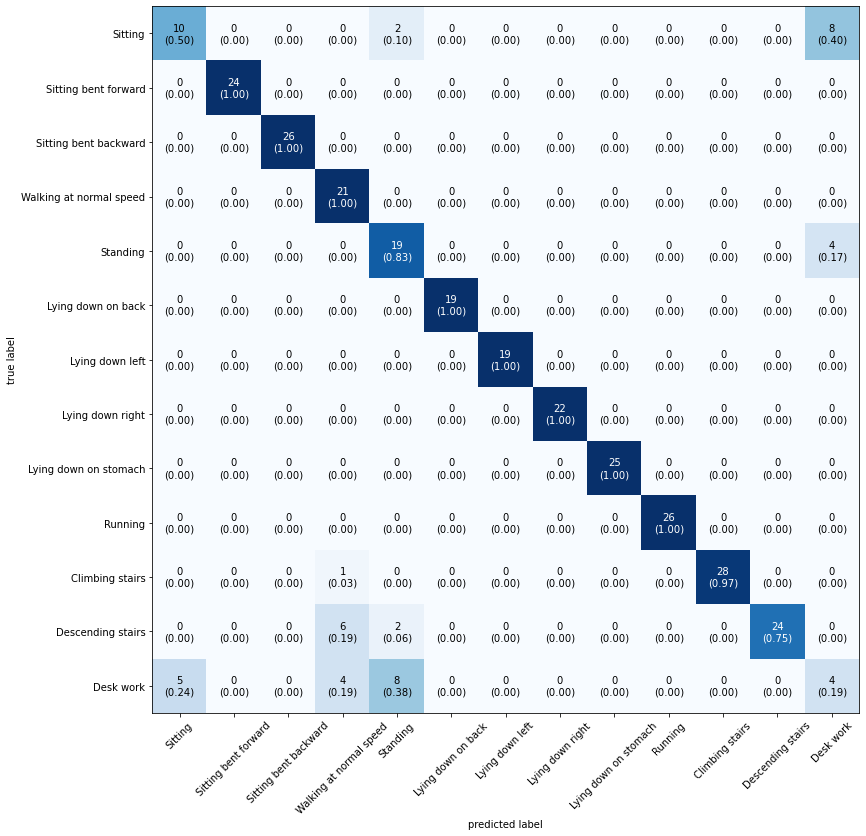

In [141]:
mat = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(conf_mat=mat, class_names=pp.new_activity_dict.values(), show_normed=True, figsize=(13,13))

## Convert Model to TF Lite

In [142]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_float_model = converter.convert()

float_model_size = len(tflite_float_model) / 1024
print('Float model size = %dKBs.' % float_model_size)

Float model size = 1417KBs.


In [143]:
f = open('chesthar.tflite', "wb")
f.write(tflite_float_model)
f.close()

print('`chesthar.tflite` has been downloaded')

`chesthar.tflite` has been downloaded


# 1d CNN 2 layers -16/32U

In [98]:
model = Sequential()

model.add(Conv1D(filters=16, kernel_size=2, activation='relu', input_shape = x_train[0].shape))
model.add(Dropout(0.2))

model.add(Conv1D(filters=32, kernel_size=2, activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=1))
model.add(Flatten())

model.add(Dense(100, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(13, activation='softmax'))

In [99]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics = ['accuracy'])

In [100]:
history = model.fit(x_train, y_train, epochs=25, batch_size = 16, validation_data = (x_test, y_test), verbose=1)

Train on 14997 samples, validate on 252 samples
Epoch 1/10
14997/14997 [==============================] - 9s 572us/sample - loss: 1.7862 - accuracy: 0.3937 - val_loss: 1.2021 - val_accuracy: 0.5992
Epoch 2/10
14997/14997 [==============================] - 7s 445us/sample - loss: 1.3211 - accuracy: 0.5277 - val_loss: 0.9313 - val_accuracy: 0.5833
Epoch 3/10
14997/14997 [==============================] - 7s 450us/sample - loss: 1.1885 - accuracy: 0.5702 - val_loss: 0.8277 - val_accuracy: 0.6587
Epoch 4/10
14997/14997 [==============================] - 7s 455us/sample - loss: 1.1082 - accuracy: 0.5947 - val_loss: 0.8331 - val_accuracy: 0.6270
Epoch 5/10
14997/14997 [==============================] - 7s 473us/sample - loss: 1.0614 - accuracy: 0.6060 - val_loss: 0.8484 - val_accuracy: 0.6706
Epoch 6/10
14997/14997 [==============================] - 7s 459us/sample - loss: 1.0340 - accuracy: 0.6165 - val_loss: 0.8253 - val_accuracy: 0.6667
Epoch 7/10
14997/14997 [============================

# 1d CNN 2 layers -128/128U

In [ ]:
model = Sequential()

model.add(Conv1D(filters=128, kernel_size=2, activation='relu', input_shape = x_train[0].shape))
model.add(Dropout(0.2))

model.add(Conv1D(filters=128, kernel_size=2, activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=1))
model.add(Flatten())

model.add(Dense(100, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(13, activation='softmax'))

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
history = model.fit(x_train, y_train, epochs=25, batch_size = 16, validation_data = (x_test, y_test), verbose=1)

# 1D CNN with L2 - 2 layers -128/128U

In [ ]:
model = Sequential()

model.add(Conv1D(filters=128, kernel_size=2, activation='relu', input_shape = x_train[0].shape, kernel_regularizer=l2(0.000001), bias_regularizer=l2(0.000001)))
model.add(Dropout(0.2))

model.add(Conv1D(filters=128, kernel_size=2, activation='relu', kernel_regularizer=l2(0.000001), bias_regularizer=l2(0.000001)))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=1))
model.add(Flatten())

model.add(Dense(100, activation='relu', kernel_regularizer=l2(0.000001), bias_regularizer=l2(0.000001)))
model.add(Dropout(0.5))

model.add(Dense(14, activation='softmax', kernel_regularizer=l2(0.000001), bias_regularizer=l2(0.000001)))

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
history = model.fit(x_train, y_train, epochs=25, batch_size = 16, validation_data = (x_test, y_test), verbose=1)

# 1D CNN with L2 - 2 layers -16/32U

In [67]:
model = Sequential()

model.add(Conv1D(filters=16, kernel_size=2, activation='relu', input_shape = x_train[0].shape, kernel_regularizer=l2(0.000001), bias_regularizer=l2(0.000001)))
model.add(Dropout(0.2))

model.add(Conv1D(filters=32, kernel_size=2, activation='relu', kernel_regularizer=l2(0.000001), bias_regularizer=l2(0.000001)))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=1))
model.add(Flatten())

model.add(Dense(100, activation='relu', kernel_regularizer=l2(0.000001), bias_regularizer=l2(0.000001)))
model.add(Dropout(0.5))

model.add(Dense(14, activation='softmax', kernel_regularizer=l2(0.000001), bias_regularizer=l2(0.000001)))

In [68]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics = ['accuracy'])

In [69]:
history = model.fit(x_train, y_train, epochs=25, batch_size = 16, validation_data = (x_test, y_test), verbose=1)

Train on 14997 samples, validate on 252 samples
Epoch 1/10
14997/14997 [==============================] - 9s 621us/sample - loss: 1.7688 - accuracy: 0.3976 - val_loss: 1.1895 - val_accuracy: 0.5476
Epoch 2/10
14997/14997 [==============================] - 8s 564us/sample - loss: 1.3778 - accuracy: 0.5154 - val_loss: 1.0642 - val_accuracy: 0.5952
Epoch 3/10
14997/14997 [==============================] - 10s 685us/sample - loss: 1.2187 - accuracy: 0.5640 - val_loss: 1.0621 - val_accuracy: 0.6032
Epoch 4/10
14997/14997 [==============================] - 10s 645us/sample - loss: 1.1163 - accuracy: 0.5960 - val_loss: 0.9222 - val_accuracy: 0.6310
Epoch 5/10
14997/14997 [==============================] - 8s 506us/sample - loss: 1.0650 - accuracy: 0.6115 - val_loss: 0.9609 - val_accuracy: 0.5992
Epoch 6/10
14997/14997 [==============================] - 7s 491us/sample - loss: 1.0404 - accuracy: 0.6186 - val_loss: 0.8599 - val_accuracy: 0.6190
Epoch 7/10
14997/14997 [==========================

# 

# 

# 2D CNN - 1 layer - 16U

In [ ]:
model = Sequential()
model.add(tf.keras.layers.Reshape((3, 25, 1), input_shape=(3,25)))
model.add(Conv2D(16, (2,2), activation='relu', input_shape = model.output_shape))
model.add(Dropout(0.2))
model.add(MaxPooling2D(pool_size=1))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(13, activation='softmax'))

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
history = model.fit(x_train, y_train, epochs=25, batch_size = 32, validation_data = (x_test, y_test), verbose=1)

# 2D CNN - 1 layer - 32U

In [ ]:
model = Sequential()
model.add(tf.keras.layers.Reshape((3, 25, 1), input_shape=(3,25)))
model.add(Conv2D(32, (2,2), activation='relu', input_shape = model.output_shape))
model.add(Dropout(0.2))
model.add(MaxPooling2D(pool_size=1))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(13, activation='softmax'))

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
history = model.fit(x_train, y_train, epochs=25, batch_size = 32, validation_data = (x_test, y_test), verbose=1)

# 2D CNN - 1 layer - 64U

In [ ]:
model = Sequential()
model.add(tf.keras.layers.Reshape((3, 25, 1), input_shape=(3,25)))
model.add(Conv2D(64, (2,2), activation='relu', input_shape = model.output_shape))
model.add(Dropout(0.2))
model.add(MaxPooling2D(pool_size=1))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(13, activation='softmax'))

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
history = model.fit(x_train, y_train, epochs=25, batch_size = 32, validation_data = (x_test, y_test), verbose=1)

# 2D CNN - 1 layer - 128U

In [ ]:
model = Sequential()
model.add(tf.keras.layers.Reshape((3, 25, 1), input_shape=(3,25)))
model.add(Conv2D(128, (2,2), activation='relu', input_shape = model.output_shape))
model.add(Dropout(0.2))
model.add(MaxPooling2D(pool_size=1))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(13, activation='softmax'))

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
history = model.fit(x_train, y_train, epochs=25, batch_size = 32, validation_data = (x_test, y_test), verbose=1)

# 2D CNN w L2 - 1 layer - 16U

In [ ]:
model = Sequential()
model.add(tf.keras.layers.Reshape((3, 25, 1), input_shape=(3,25)))
model.add(Conv2D(16, (2,2), activation='relu', input_shape = model.output_shape, kernel_regularizer=l2(0.000001), bias_regularizer=l2(0.000001)))
model.add(Dropout(0.2))
model.add(MaxPooling2D(pool_size=1))
model.add(Flatten())
model.add(Dense(100, activation='relu', kernel_regularizer=l2(0.000001), bias_regularizer=l2(0.000001)))
model.add(Dropout(0.5))

model.add(Dense(14, activation='softmax', kernel_regularizer=l2(0.000001), bias_regularizer=l2(0.000001)))

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
history = model.fit(x_train, y_train, epochs=25, batch_size = 32, validation_data = (x_test, y_test), verbose=1)

# 2D CNN w L2 - 1 layer - 32U

In [ ]:
model = Sequential()
model.add(tf.keras.layers.Reshape((3, 25, 1), input_shape=(3,25)))
model.add(Conv2D(32, (2,2), activation='relu', input_shape = model.output_shape, kernel_regularizer=l2(0.000001), bias_regularizer=l2(0.000001)))
model.add(Dropout(0.2))
model.add(MaxPooling2D(pool_size=1))
model.add(Flatten())
model.add(Dense(100, activation='relu', kernel_regularizer=l2(0.000001), bias_regularizer=l2(0.000001)))
model.add(Dropout(0.5))

model.add(Dense(14, activation='softmax', kernel_regularizer=l2(0.000001), bias_regularizer=l2(0.000001)))

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
history = model.fit(x_train, y_train, epochs=25, batch_size = 32, validation_data = (x_test, y_test), verbose=1)

# 2D CNN w L2 - 1 layer - 64U

In [ ]:
model = Sequential()
model.add(tf.keras.layers.Reshape((3, 25, 1), input_shape=(3,25)))
model.add(Conv2D(64, (2,2), activation='relu', input_shape = model.output_shape, kernel_regularizer=l2(0.000001), bias_regularizer=l2(0.000001)))
model.add(Dropout(0.2))
model.add(MaxPooling2D(pool_size=1))
model.add(Flatten())
model.add(Dense(100, activation='relu', kernel_regularizer=l2(0.000001), bias_regularizer=l2(0.000001)))
model.add(Dropout(0.5))

model.add(Dense(14, activation='softmax', kernel_regularizer=l2(0.000001), bias_regularizer=l2(0.000001)))

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
history = model.fit(x_train, y_train, epochs=25, batch_size = 32, validation_data = (x_test, y_test), verbose=1)

# 2D CNN w L2 - 1 layer - 128U

In [ ]:
model = Sequential()
model.add(tf.keras.layers.Reshape((3, 25, 1), input_shape=(3,25)))
model.add(Conv2D(128, (2,2), activation='relu', input_shape = model.output_shape, kernel_regularizer=l2(0.000001), bias_regularizer=l2(0.000001)))
model.add(Dropout(0.2))
model.add(MaxPooling2D(pool_size=1))
model.add(Flatten())
model.add(Dense(100, activation='relu', kernel_regularizer=l2(0.000001), bias_regularizer=l2(0.000001)))
model.add(Dropout(0.5))

model.add(Dense(14, activation='softmax', kernel_regularizer=l2(0.000001), bias_regularizer=l2(0.000001)))

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
history = model.fit(x_train, y_train, epochs=25, batch_size = 32, validation_data = (x_test, y_test), verbose=1)

# 1D CNN - 1 layer - 16U

In [ ]:
model = Sequential()

model.add(Conv1D(filters=16, kernel_size=2, activation='relu', input_shape = x_train[0].shape))
model.add(Dropout(0.2))
model.add(MaxPooling1D(pool_size=1))
model.add(Flatten())

model.add(Dense(100, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(13, activation='softmax'))

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
history = model.fit(x_train, y_train, epochs=25, batch_size = 32, validation_data = (x_test, y_test), verbose=1)

# 1D CNN - 1 layer - 32U

In [ ]:
model = Sequential()

model.add(Conv1D(filters=32, kernel_size=2, activation='relu', input_shape = x_train[0].shape))
model.add(Dropout(0.2))
model.add(MaxPooling1D(pool_size=1))
model.add(Flatten())

model.add(Dense(100, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(13, activation='softmax'))

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
history = model.fit(x_train, y_train, epochs=25, batch_size = 32, validation_data = (x_test, y_test), verbose=1)

# 1D CNN - 1 layer - 64U

In [ ]:
model = Sequential()

model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape = x_train[0].shape))
model.add(Dropout(0.2))
model.add(MaxPooling1D(pool_size=1))
model.add(Flatten())

model.add(Dense(100, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(13, activation='softmax'))

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
history = model.fit(x_train, y_train, epochs=25, batch_size = 32, validation_data = (x_test, y_test), verbose=1)

# 1D CNN - 1 layer - 128U

In [ ]:
model = Sequential()

model.add(Conv1D(filters=128, kernel_size=2, activation='relu', input_shape = x_train[0].shape))
model.add(Dropout(0.2))
model.add(MaxPooling1D(pool_size=1))
model.add(Flatten())

model.add(Dense(100, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(13, activation='softmax'))

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
history = model.fit(x_train, y_train, epochs=25, batch_size = 32, validation_data = (x_test, y_test), verbose=1)

# 1D CNN  w L2 - 1 layer - 16U

In [ ]:
model = Sequential()

model.add(Conv1D(filters=16, kernel_size=2, activation='relu', input_shape = x_train[0].shape, kernel_regularizer=l2(0.000001), bias_regularizer=l2(0.000001)))
model.add(Dropout(0.2))

model.add(MaxPooling1D(pool_size=1))
model.add(Flatten())

model.add(Dense(100, activation='relu', kernel_regularizer=l2(0.000001), bias_regularizer=l2(0.000001)))
model.add(Dropout(0.5))

model.add(Dense(14, activation='softmax', kernel_regularizer=l2(0.000001), bias_regularizer=l2(0.000001)))

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
history = model.fit(x_train, y_train, epochs=25, batch_size = 32, validation_data = (x_test, y_test), verbose=1)

# 1D CNN  w L2 - 1 layer - 32U

In [ ]:
model = Sequential()

model.add(Conv1D(filters=32, kernel_size=2, activation='relu', input_shape = x_train[0].shape, kernel_regularizer=l2(0.000001), bias_regularizer=l2(0.000001)))
model.add(Dropout(0.2))

model.add(MaxPooling1D(pool_size=1))
model.add(Flatten())

model.add(Dense(100, activation='relu', kernel_regularizer=l2(0.000001), bias_regularizer=l2(0.000001)))
model.add(Dropout(0.5))

model.add(Dense(14, activation='softmax', kernel_regularizer=l2(0.000001), bias_regularizer=l2(0.000001)))

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
history = model.fit(x_train, y_train, epochs=25, batch_size = 32, validation_data = (x_test, y_test), verbose=1)

# 1D CNN  w L2 - 1 layer - 64U

In [ ]:
model = Sequential()

model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape = x_train[0].shape, kernel_regularizer=l2(0.000001), bias_regularizer=l2(0.000001)))
model.add(Dropout(0.2))

model.add(MaxPooling1D(pool_size=1))
model.add(Flatten())

model.add(Dense(100, activation='relu', kernel_regularizer=l2(0.000001), bias_regularizer=l2(0.000001)))
model.add(Dropout(0.5))

model.add(Dense(14, activation='softmax', kernel_regularizer=l2(0.000001), bias_regularizer=l2(0.000001)))

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
history = model.fit(x_train, y_train, epochs=25, batch_size = 32, validation_data = (x_test, y_test), verbose=1)

# 1D CNN  w L2 - 1 layer - 128U

In [ ]:
model = Sequential()

model.add(Conv1D(filters=128, kernel_size=2, activation='relu', input_shape = x_train[0].shape, kernel_regularizer=l2(0.000001), bias_regularizer=l2(0.000001)))
model.add(Dropout(0.2))

model.add(MaxPooling1D(pool_size=1))
model.add(Flatten())

model.add(Dense(100, activation='relu', kernel_regularizer=l2(0.000001), bias_regularizer=l2(0.000001)))
model.add(Dropout(0.5))

model.add(Dense(14, activation='softmax', kernel_regularizer=l2(0.000001), bias_regularizer=l2(0.000001)))

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
history = model.fit(x_train, y_train, epochs=25, batch_size = 32, validation_data = (x_test, y_test), verbose=1)